# Predicting Diabetes Risk Using Machine Learning: A Proof-of-Concept Study

## Abstract

Diabetes mellitus affects over 37 million Americans and is a leading cause of cardiovascular disease, kidney failure, and blindness. Early detection is critical for prevention and management, yet traditional screening methods rely heavily on physician assessment and may miss at-risk individuals. Current limitations include the reactive nature of diagnosis—often occurring after complications have begun—and limited predictive capabilities beyond established risk factors.

This notebook demonstrates how machine learning can potentially address this gap by building predictive models that identify diabetes risk using readily available clinical measurements. Using the Pima Indians Diabetes dataset, we'll develop multiple classification models (traditional ML and deep learning) that predict diabetes likelihood based on factors including glucose levels, BMI, age, and family history. If successful, such models could enable earlier intervention, personalized risk assessment, and more efficient allocation of preventive care resources.

We'll walk through the complete AI workflow: data preparation and exploration, model selection and training (comparing 5 different algorithms), performance evaluation using clinically relevant metrics, and results visualization. This proof-of-concept demonstrates how both traditional machine learning and deep learning approaches can be applied to health prediction tasks.

**Dataset:** Pima Indians Diabetes Database (National Institute of Diabetes and Digestive and Kidney Diseases)  
**Models:** Logistic Regression, Random Forest, XGBoost, SVM, Neural Network (5 layers)  
**Tools:** Python, Pandas, Scikit-learn, XGBoost, TensorFlow, Matplotlib, Seaborn, SHAP

In [21]:
# Data manipulation and analysis
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_curve)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


In [22]:
 #Load the diabetes dataset
df = pd.read_csv('/Users/edgarocasio/Downloads/diabetes.csv')

# Display first few rows
print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded successfully!

Dataset shape: 768 rows, 9 columns


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Why This Dataset?

The Pima Indians Diabetes dataset is ideal for demonstrating AI in health because:
- **Clinical relevance:** Uses real medical measurements
- **Clear outcome:** Binary classification (diabetes: yes/no)
- **Manageable size:** ~768 patients, perfect for learning
- **Well-documented:** Widely used in ML education and research

## Features Explanation

- **Pregnancies:** Number of times pregnant
- **Glucose:** Plasma glucose concentration (2 hours in oral glucose tolerance test)
- **BloodPressure:** Diastolic blood pressure (mm Hg)
- **SkinThickness:** Triceps skin fold thickness (mm)
- **Insulin:** 2-Hour serum insulin (mu U/ml)
- **BMI:** Body mass index (weight in kg/(height in m)^2)
- **DiabetesPedigreeFunction:** Diabetes pedigree function (genetic influence score)
- **Age:** Age in years
- **Outcome:** Target variable (0 = no diabetes, 1 = diabetes)

In [23]:
# Basic dataset information
print("=== Dataset Information ===")
print(df.info())
print("\n=== Statistical Summary ===")
print(df.describe())
print("\n=== Missing Values ===")
print(df.isnull().sum())
print("\n=== Class Distribution ===")
print(df['Outcome'].value_counts())
print(f"\nDiabetes prevalence in dataset: {df['Outcome'].mean()*100:.1f}%")

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Statistical Summary ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.89

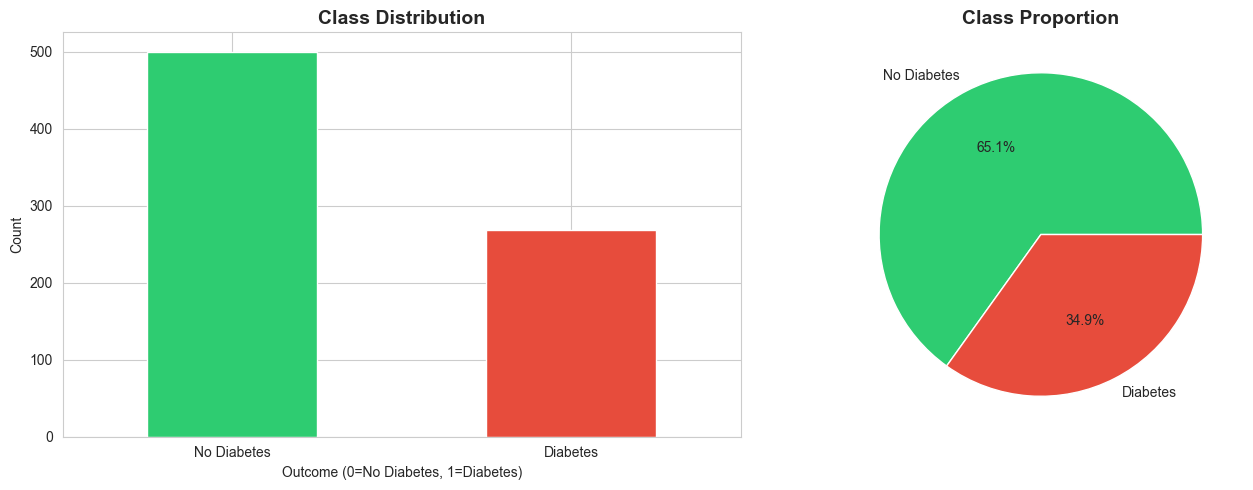

Why this matters: Understanding class imbalance helps us choose appropriate evaluation metrics.


In [24]:
# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['Outcome'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Outcome (0=No Diabetes, 1=Diabetes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Diabetes', 'Diabetes'], rotation=0)

# Pie chart
df['Outcome'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                   colors=['#2ecc71', '#e74c3c'], labels=['No Diabetes', 'Diabetes'])
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("Why this matters: Understanding class imbalance helps us choose appropriate evaluation metrics.")

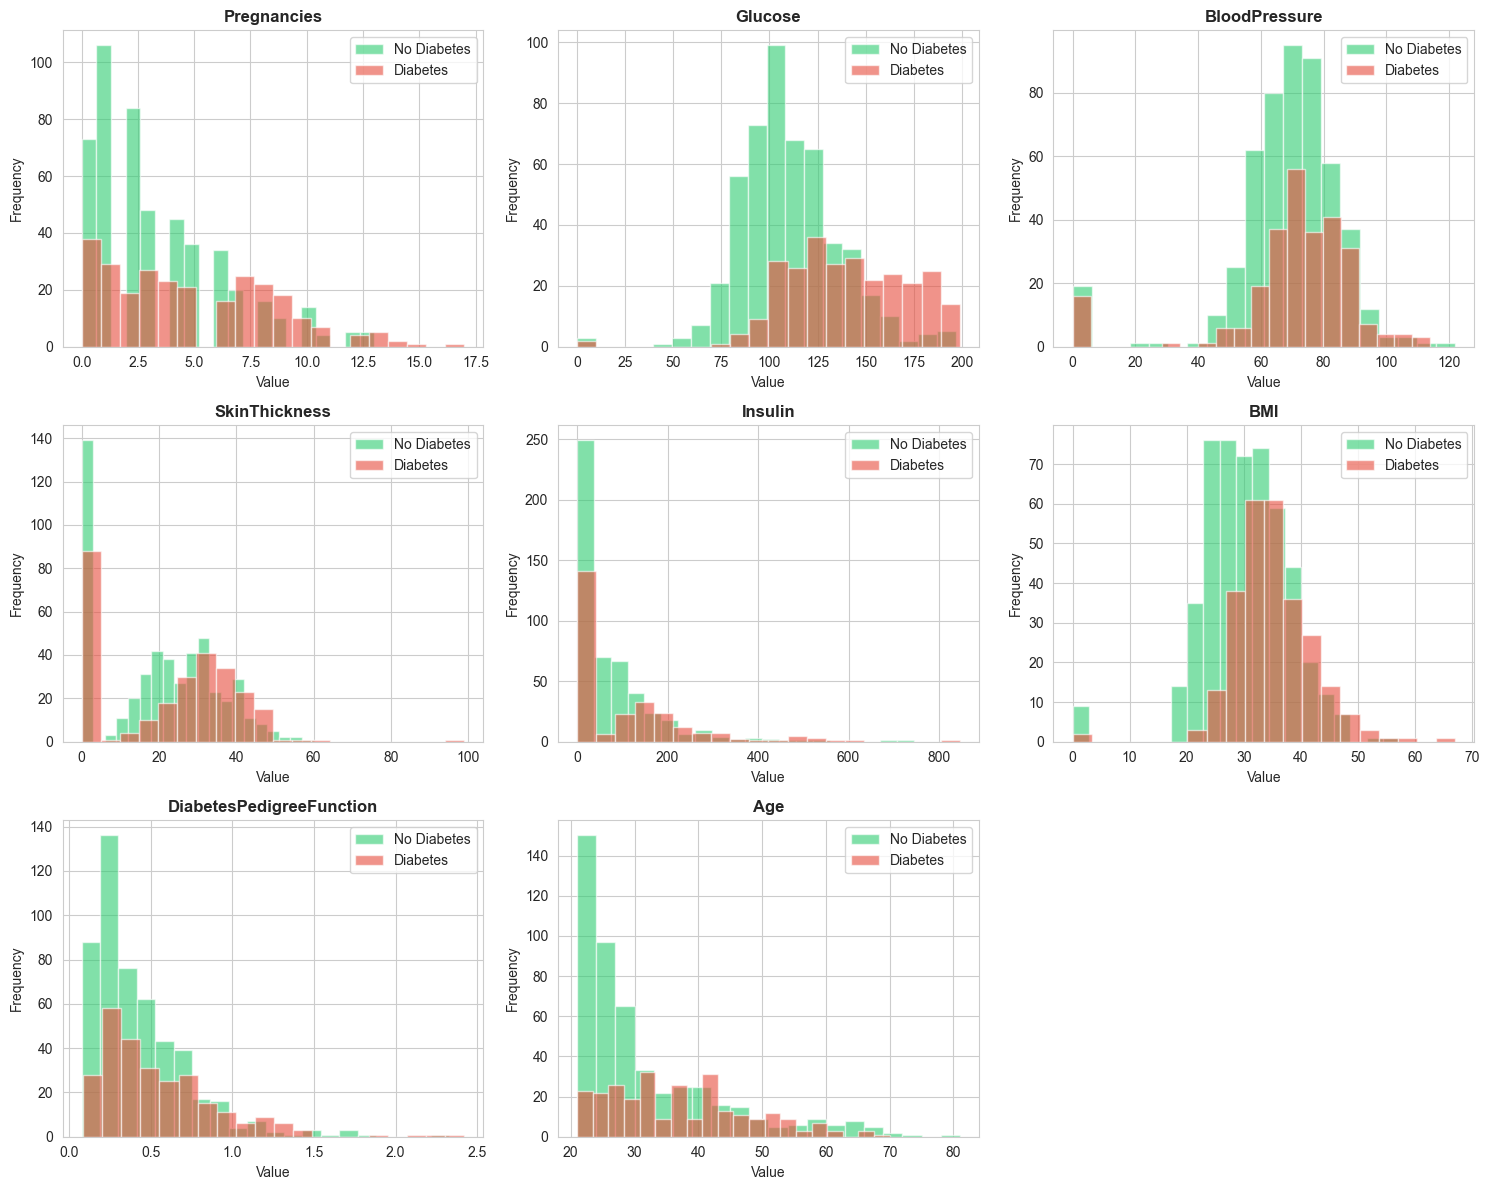

Observation: Notice how Glucose and BMI show clear separation between classes - these are likely important predictors!


In [25]:
# Visualize distributions of all features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:-1]):  # Exclude 'Outcome'
    axes[idx].hist(df[df['Outcome']==0][col], bins=20, alpha=0.6, label='No Diabetes', color='#2ecc71')
    axes[idx].hist(df[df['Outcome']==1][col], bins=20, alpha=0.6, label='Diabetes', color='#e74c3c')
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

# Remove empty subplot
fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

print("Observation: Notice how Glucose and BMI show clear separation between classes - these are likely important predictors!")

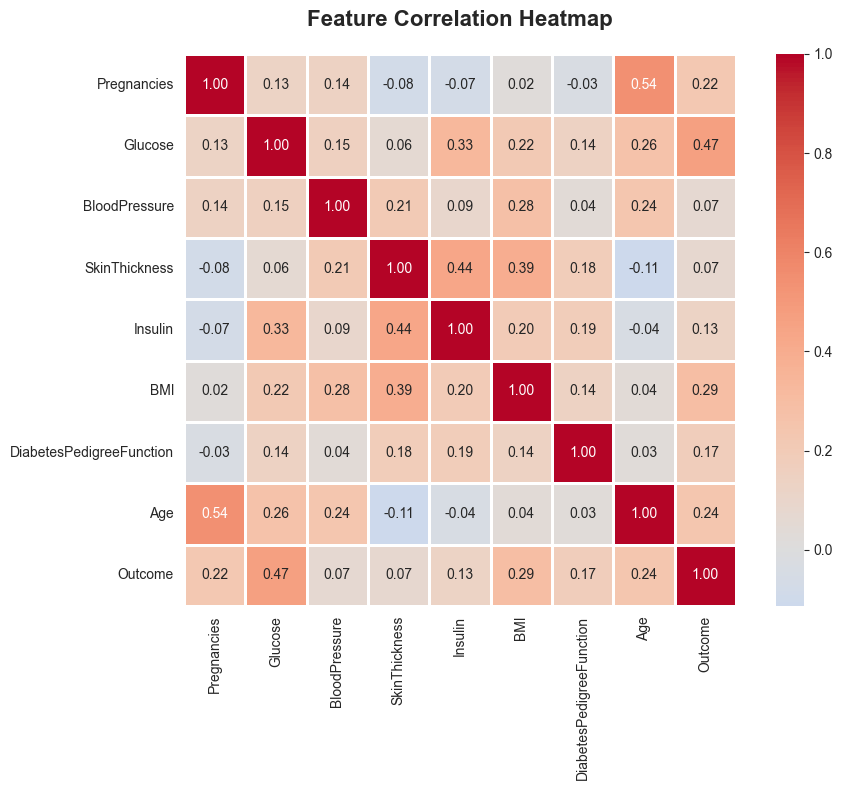


=== Features Most Correlated with Diabetes ===
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [26]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n=== Features Most Correlated with Diabetes ===")
print(correlation_matrix['Outcome'].sort_values(ascending=False))

## Data Preprocessing: Why It Matters

Before training our model, we need to prepare the data:

### 1. **Handling Zero Values**
Medical measurements like Glucose, BloodPressure, and BMI cannot truly be zero - these are likely missing values. We have options:
- Replace with median/mean
- Remove rows
- Use advanced imputation

**Our choice:** Replace zeros with median values (more robust to outliers than mean)

### 2. **Feature Scaling**
Machine learning algorithms perform better when features are on similar scales. Random Forests don't strictly require scaling, but neural networks do.

**Our choice:** StandardScaler (converts features to mean=0, std=1)

### 3. **Train-Test Split**
We need separate data to evaluate model performance on unseen data.

**Our choice:** 80-20 split (common standard for this dataset size)

In [27]:
# Identify columns that shouldn't have zero values
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Check zeros before replacement
print("=== Zero values before cleaning ===")
for column in zero_not_accepted:
    print(f"{column}: {(df[column] == 0).sum()} zeros ({(df[column] == 0).sum()/len(df)*100:.1f}%)")

# Replace zeros with median
for column in zero_not_accepted:
    df[column] = df[column].replace(0, df[column].median())

print("\n=== After replacement ===")
print("All zeros in critical columns replaced with median values.")
print("\nWhy median? It's robust to outliers, unlike mean.")

=== Zero values before cleaning ===
Glucose: 5 zeros (0.7%)
BloodPressure: 35 zeros (4.6%)
SkinThickness: 227 zeros (29.6%)
Insulin: 374 zeros (48.7%)
BMI: 11 zeros (1.4%)

=== After replacement ===
All zeros in critical columns replaced with median values.

Why median? It's robust to outliers, unlike mean.


In [28]:
# Advanced outlier detection and handling
def detect_outliers_iqr(df, columns):
    """Detect outliers using Interquartile Range method"""
    outlier_indices = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list)
    
    return outlier_indices

# Detect outliers
outlier_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
outliers = detect_outliers_iqr(df, outlier_columns)

print(f"Total outliers detected: {len(set(outliers))} rows")
print(f"Percentage of data: {len(set(outliers))/len(df)*100:.1f}%")

# Option: Remove extreme outliers (we'll keep for now to preserve data)
print("\n✓ Outliers detected but retained for model robustness")
print("Note: Random Forest and Neural Networks are robust to outliers, so we keep all data points")

Total outliers detected: 109 rows
Percentage of data: 14.2%

✓ Outliers detected but retained for model robustness
Note: Random Forest and Neural Networks are robust to outliers, so we keep all data points


In [29]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set diabetes rate: {y_train.mean()*100:.1f}%")
print(f"Testing set diabetes rate: {y_test.mean()*100:.1f}%")
print("\nNote: stratify=y ensures both sets have similar class distributions")

Training set size: 614 samples
Testing set size: 154 samples

Training set diabetes rate: 34.9%
Testing set diabetes rate: 35.1%

Note: stratify=y ensures both sets have similar class distributions


In [30]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Feature scaling completed!")
print("\n=== Example: Before and After Scaling ===")
print("\nOriginal Glucose values (first 5):")
print(X_train['Glucose'].head().values)
print("\nScaled Glucose values (first 5):")
print(X_train_scaled['Glucose'].head().values)
print("\nScaled features now have mean ≈ 0 and standard deviation ≈ 1")

Feature scaling completed!

=== Example: Before and After Scaling ===

Original Glucose values (first 5):
[ 90 126 105 146  95]

Scaled Glucose values (first 5):
[-1.05642747  0.14439907 -0.55608308  0.81152492 -0.88964601]

Scaled features now have mean ≈ 0 and standard deviation ≈ 1


## Model Selection: Multiple Algorithm Comparison

Instead of using just one model, we'll train and compare **5 different algorithms** to find the best performer:

### Traditional Machine Learning Models:

1. **Logistic Regression** 
   - Baseline linear model
   - Fast, interpretable
   - Good for understanding linear relationships

2. **Random Forest Classifier**
   - Ensemble of decision trees
   - Handles non-linearity well
   - Provides feature importance

3. **Gradient Boosting (XGBoost)**
   - State-of-the-art boosting algorithm
   - Often achieves highest accuracy
   - Sequential error correction

4. **Support Vector Machine (SVM)**
   - Finds optimal decision boundary
   - Good with high-dimensional data
   - Kernel trick for non-linearity

### Deep Learning Model:

5. **Neural Network (5 Layers)**
   - Input layer (8 features)
   - Hidden layer 1: 64 neurons + ReLU + BatchNorm + Dropout
   - Hidden layer 2: 32 neurons + ReLU + BatchNorm + Dropout
   - Hidden layer 3: 16 neurons + ReLU + BatchNorm + Dropout
   - Output layer: 1 neuron + Sigmoid
   - **Total parameters: ~5,000+**

### Advanced Techniques We'll Use:
- **Cross-validation:** 5-fold CV for robust evaluation
- **Hyperparameter tuning:** Grid search for optimal parameters
- **Early stopping:** Prevents neural network overfitting
- **Learning rate scheduling:** Adaptive learning for neural networks
- **SHAP values:** Explainable AI for model interpretation

**Tools:** scikit-learn, XGBoost, TensorFlow/Keras

In [31]:
import xgboost
import os

In [32]:
# Install TensorFlow for deep learning
try:
    import tensorflow as tf
    print(f"✓ TensorFlow {tf.__version__} already installed")
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    print(f"✓ TensorFlow {tf.__version__} installed successfully")

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("\n✓ Ready for deep learning!")

✓ TensorFlow 2.20.0 already installed

✓ Ready for deep learning!


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb
import time

print("=" * 60)
print("TRAINING MULTIPLE MODELS WITH CROSS-VALIDATION")
print("=" * 60)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42)
}

# Store results
cv_results = {}
trained_models = {}

# Train and evaluate each model with 5-fold cross-validation
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Train on full training set
    model.fit(X_train_scaled, y_train)
    
    # Store results
    cv_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    trained_models[name] = model
    
    training_time = time.time() - start_time
    
    print(f"✓ Cross-validation Accuracy: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)")
    print(f"  Individual fold scores: {[f'{s*100:.1f}%' for s in cv_scores]}")
    print(f"  Training time: {training_time:.2f} seconds")

print(f"\n{'='*60}")
print("ALL TRADITIONAL ML MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*60}")

TRAINING MULTIPLE MODELS WITH CROSS-VALIDATION

Training: Logistic Regression
✓ Cross-validation Accuracy: 78.02% (±1.80%)
  Individual fold scores: ['77.2%', '76.4%', '76.4%', '78.9%', '81.1%']
  Training time: 0.01 seconds

Training: Random Forest
✓ Cross-validation Accuracy: 76.39% (±2.93%)
  Individual fold scores: ['76.4%', '78.9%', '70.7%', '78.0%', '77.9%']
  Training time: 0.48 seconds

Training: XGBoost
✓ Cross-validation Accuracy: 72.97% (±3.43%)
  Individual fold scores: ['67.5%', '76.4%', '70.7%', '74.0%', '76.2%']
  Training time: 0.38 seconds

Training: SVM
✓ Cross-validation Accuracy: 76.22% (±1.92%)
  Individual fold scores: ['74.8%', '78.0%', '73.2%', '77.2%', '77.9%']
  Training time: 0.11 seconds

ALL TRADITIONAL ML MODELS TRAINED SUCCESSFULLY!


In [34]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - Optimizing Random Forest")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nSearching through parameter combinations...")
print("This may take a few minutes...\n")

grid_search.fit(X_train_scaled, y_train)

print("\n✓ Hyperparameter tuning complete!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_*100:.2f}%")

# Use the best model
best_rf_model = grid_search.best_estimator_
trained_models['Random Forest (Tuned)'] = best_rf_model


HYPERPARAMETER TUNING - Optimizing Random Forest

Searching through parameter combinations...
This may take a few minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✓ Hyperparameter tuning complete!

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 77.53%


In [35]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential

print("="*70)
print("BUILDING DEEP NEURAL NETWORK")
print("="*70)

# Build neural network architecture
def create_neural_network(input_dim):
    model = Sequential([
        # Input Layer
        layers.Input(shape=(input_dim,)),
        
        # Hidden Layer 1: 64 neurons
        layers.Dense(64, activation='relu', name='Hidden_Layer_1'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden Layer 2: 32 neurons
        layers.Dense(32, activation='relu', name='Hidden_Layer_2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden Layer 3: 16 neurons
        layers.Dense(16, activation='relu', name='Hidden_Layer_3'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output Layer: 1 neuron for binary classification
        layers.Dense(1, activation='sigmoid', name='Output_Layer')
    ])
    
    return model

# Create the model
nn_model = create_neural_network(X_train_scaled.shape[1])

# Compile the model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display architecture
print("\n📊 NEURAL NETWORK ARCHITECTURE:\n")
nn_model.summary()

print("\n" + "="*70)
print("Network Structure:")
print("  Input Layer:    8 features")
print("  Hidden Layer 1: 64 neurons + ReLU + BatchNorm + Dropout(0.3)")
print("  Hidden Layer 2: 32 neurons + ReLU + BatchNorm + Dropout(0.3)")
print("  Hidden Layer 3: 16 neurons + ReLU + BatchNorm + Dropout(0.2)")
print("  Output Layer:   1 neuron + Sigmoid")
print(f"  Total Parameters: {nn_model.count_params():,}")
print("="*70)

BUILDING DEEP NEURAL NETWORK

📊 NEURAL NETWORK ARCHITECTURE:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 224 (896.00 B)


Network Structure:
  Input Layer:    8 features
  Hidden Layer 1: 64 neurons + ReLU + BatchNorm + Dropout(0.3)
  Hidden Layer 2: 32 neurons + ReLU + BatchNorm + Dropout(0.3)
  Hidden Layer 3: 16 neurons + ReLU + BatchNorm + Dropout(0.2)
  Output Layer:   1 neuron + Sigmoid
  Total Parameters: 3,649


In [36]:
print("\n" + "="*70)
print("TRAINING NEURAL NETWORK")
print("="*70 + "\n")

# Callbacks for better training
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0  # Set to 1 to see training progress
)

print("\n✓ Training completed!")
print(f"  Total epochs run: {len(history.history['loss'])}")
print(f"  Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"  Best validation AUC: {max(history.history['val_auc']):.3f}")

#


TRAINING NEURAL NETWORK


Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 59.

✓ Training completed!
  Total epochs run: 79
  Best validation accuracy: 81.30%
  Best validation AUC: 0.867


In [37]:
# Make predictions
nn_train_pred_proba = nn_model.predict(X_train_scaled, verbose=0).flatten()
nn_test_pred_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
nn_test_pred = (nn_test_pred_proba > 0.5).astype(int)

# Add to our models dictionary
trained_models['Neural Network'] = nn_model
all_predictions = {}
all_probabilities = {}

# Get predictions for all models
for name, model in trained_models.items():
    if name == 'Neural Network':
        all_predictions[name] = nn_test_pred
        all_probabilities[name] = nn_test_pred_proba
    else:
        all_predictions[name] = model.predict(X_test_scaled)
        all_probabilities[name] = model.predict_proba(X_test_scaled)[:, 1]

print("\n✓ Neural Network predictions generated")
print("✓ All model predictions ready for evaluation")


✓ Neural Network predictions generated
✓ All model predictions ready for evaluation


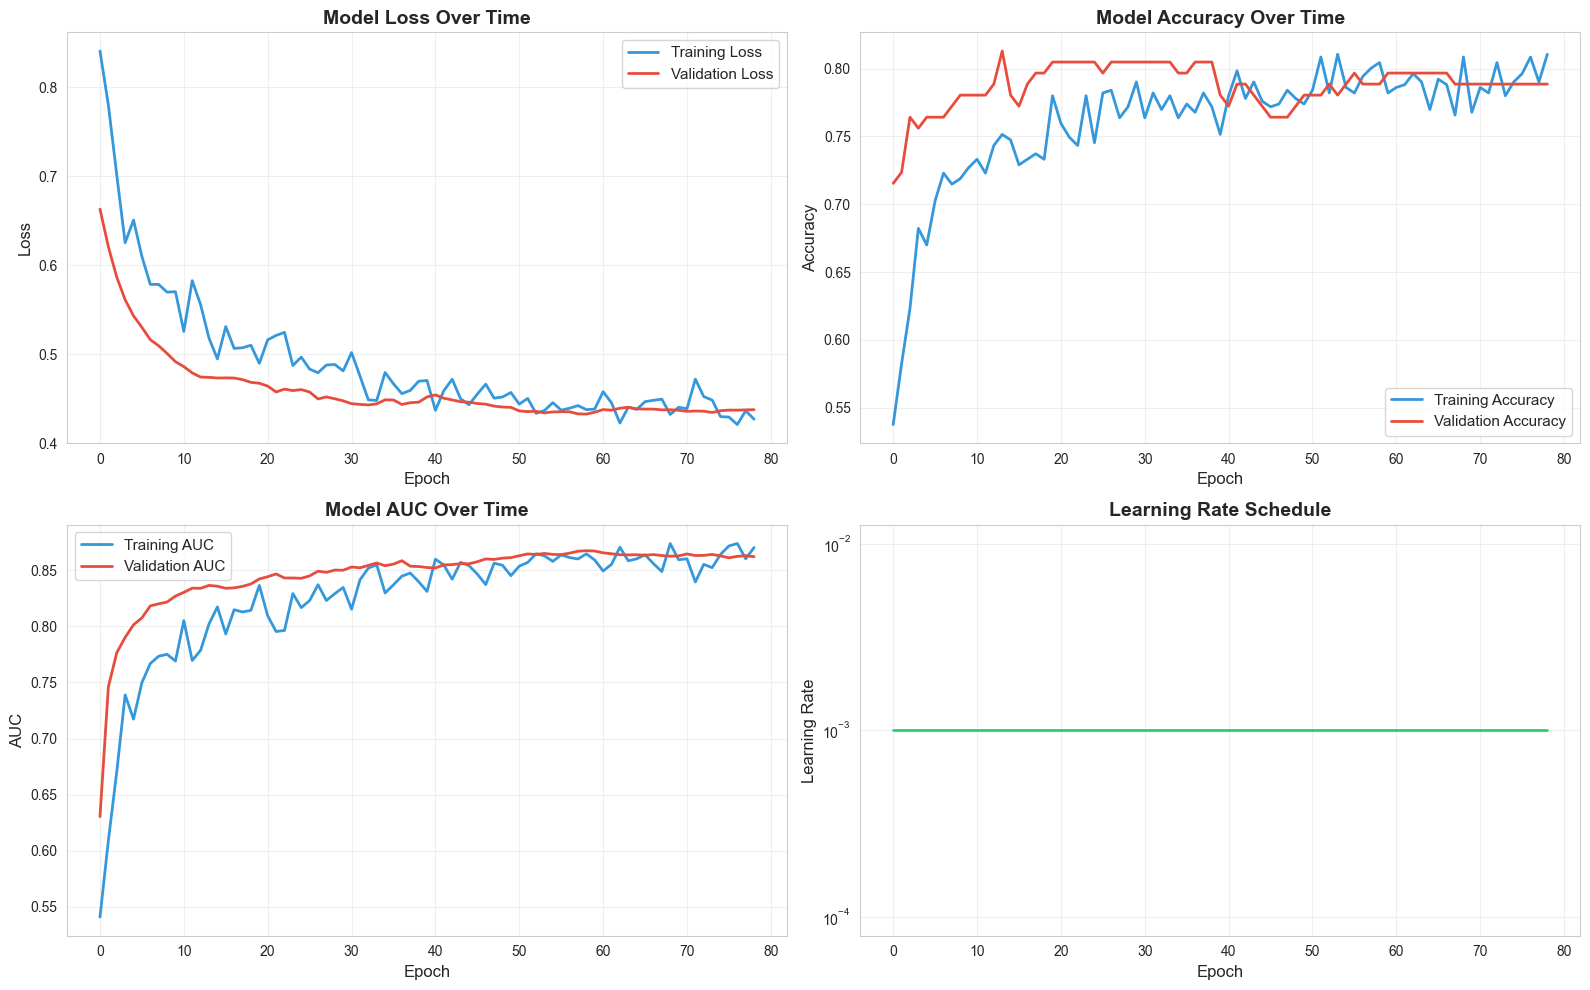


📊 Training Insights:
  • Best epoch: 14
  • Training stopped at epoch: 79
  • Final training accuracy: 81.06%
  • Final validation accuracy: 78.86%
  ✓ Good generalization (gap: 2.2%)


In [38]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Training & Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', color='#3498db', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Training & Validation Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', color='#3498db', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#e74c3c', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. AUC Score
axes[1, 0].plot(history.history['auc'], label='Training AUC', color='#3498db', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Validation AUC', color='#e74c3c', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontsize=12)
axes[1, 0].set_title('Model AUC Over Time', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning Rate Changes
axes[1, 1].plot(history.history['lr'] if 'lr' in history.history else [0.001]*len(history.history['loss']), 
                color='#2ecc71', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Insights:")
print(f"  • Best epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  • Training stopped at epoch: {len(history.history['loss'])}")
print(f"  • Final training accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"  • Final validation accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")

gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
if gap > 0.1:
    print(f"  ⚠️  Overfitting detected (gap: {gap*100:.1f}%)")
else:
    print(f"  ✓ Good generalization (gap: {gap*100:.1f}%)")

In [39]:
# Create a simple text-based architecture visualization
print("\n" + "="*70)
print("NEURAL NETWORK ARCHITECTURE DIAGRAM")
print("="*70 + "\n")

architecture = """
    INPUT LAYER
    [8 features]
         │
         ├──── Pregnancies
         ├──── Glucose
         ├──── BloodPressure
         ├──── SkinThickness
         ├──── Insulin
         ├──── BMI
         ├──── DiabetesPedigreeFunction
         └──── Age
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 1     │
    │  64 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (30%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 2     │
    │  32 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (30%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 3     │
    │  16 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (20%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    │  OUTPUT LAYER       │
    │  1 neuron           │
    │  Sigmoid activation │
    └─────────────────────┘
         │
         ▼
    [Probability: 0-1]
    (Diabetes Risk Score)
"""

print(architecture)
print("="*70)
print(f"Total Trainable Parameters: {nn_model.count_params():,}")
print("="*70)


NEURAL NETWORK ARCHITECTURE DIAGRAM


    INPUT LAYER
    [8 features]
         │
         ├──── Pregnancies
         ├──── Glucose
         ├──── BloodPressure
         ├──── SkinThickness
         ├──── Insulin
         ├──── BMI
         ├──── DiabetesPedigreeFunction
         └──── Age
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 1     │
    │  64 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (30%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 2     │
    │  32 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (30%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    │  HIDDEN LAYER 3     │
    │  16 neurons         │
    │  ReLU activation    │
    │  BatchNormalization │
    │  Dropout (20%)      │
    └─────────────────────┘
         │
         ▼
    ┌─────────────────────┐
    

In [40]:
print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70 + "\n")

# Store all performance metrics
performance_metrics = []

for name, y_pred in all_predictions.items():
    y_proba = all_probabilities[name]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # Recall / True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    # Negative Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    performance_metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'NPV': npv,
        'F1-Score': f1
    })
    
    print(f"{name}:")
    print(f"  Accuracy:    {accuracy*100:.2f}%")
    print(f"  ROC AUC:     {roc_auc:.3f}")
    print(f"  Sensitivity: {sensitivity*100:.2f}% (catches {sensitivity*100:.1f}% of diabetes cases)")
    print(f"  Specificity: {specificity*100:.2f}% (correctly identifies {specificity*100:.1f}% of non-diabetes)")
    print(f"  Precision:   {precision*100:.2f}% (when predicts diabetes, correct {precision*100:.1f}% of time)")
    print(f"  F1-Score:    {f1:.3f}")
    print()

# Create comparison DataFrame
performance_df = pd.DataFrame(performance_metrics)
performance_df = performance_df.sort_values('ROC AUC', ascending=False)

print("\n" + "="*70)
print("📊 SUMMARY TABLE (Ranked by ROC AUC):")
print("="*70)
print(performance_df.to_string(index=False))

best_model_name = performance_df.iloc[0]['Model']
best_auc = performance_df.iloc[0]['ROC AUC']
print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name} (AUC = {best_auc:.3f})")
print(f"{'='*70}")


MODEL COMPARISON - TEST SET PERFORMANCE

Logistic Regression:
  Accuracy:    70.78%
  ROC AUC:     0.815
  Sensitivity: 50.00% (catches 50.0% of diabetes cases)
  Specificity: 82.00% (correctly identifies 82.0% of non-diabetes)
  Precision:   60.00% (when predicts diabetes, correct 60.0% of time)
  F1-Score:    0.545

Random Forest:
  Accuracy:    75.97%
  ROC AUC:     0.820
  Sensitivity: 59.26% (catches 59.3% of diabetes cases)
  Specificity: 85.00% (correctly identifies 85.0% of non-diabetes)
  Precision:   68.09% (when predicts diabetes, correct 68.1% of time)
  F1-Score:    0.634

XGBoost:
  Accuracy:    73.38%
  ROC AUC:     0.810
  Sensitivity: 59.26% (catches 59.3% of diabetes cases)
  Specificity: 81.00% (correctly identifies 81.0% of non-diabetes)
  Precision:   62.75% (when predicts diabetes, correct 62.7% of time)
  F1-Score:    0.610

SVM:
  Accuracy:    73.38%
  ROC AUC:     0.794
  Sensitivity: 53.70% (catches 53.7% of diabetes cases)
  Specificity: 84.00% (correctly id

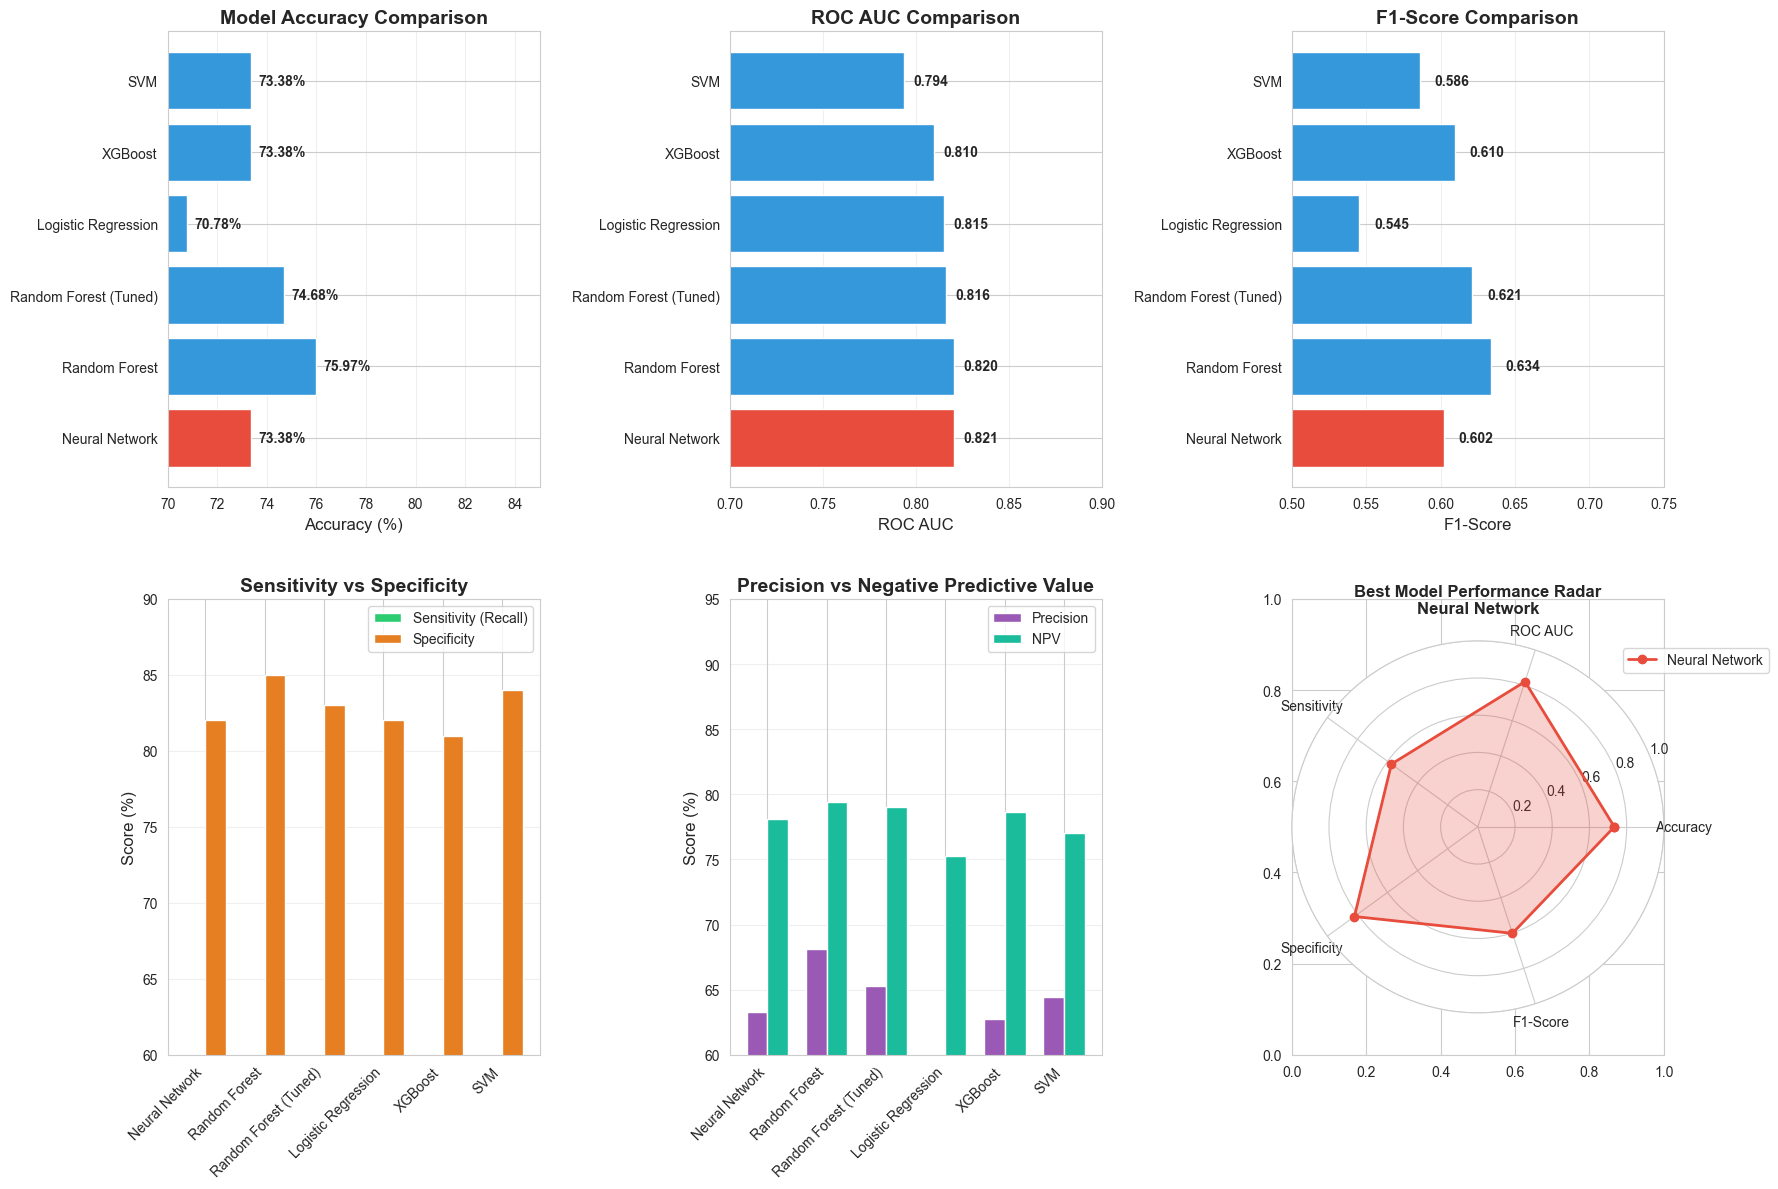

✓ Comprehensive comparison visualizations complete!


In [41]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
colors_acc = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(performance_df))]
bars = ax1.barh(performance_df['Model'], performance_df['Accuracy']*100, color=colors_acc)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([70, 85])
for i, (bar, val) in enumerate(zip(bars, performance_df['Accuracy']*100)):
    ax1.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.2f}%', 
             va='center', fontsize=10, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. ROC AUC Comparison
ax2 = axes[0, 1]
colors_auc = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(performance_df))]
bars = ax2.barh(performance_df['Model'], performance_df['ROC AUC'], color=colors_auc)
ax2.set_xlabel('ROC AUC', fontsize=12)
ax2.set_title('ROC AUC Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim([0.70, 0.90])
for i, (bar, val) in enumerate(zip(bars, performance_df['ROC AUC'])):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=10, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. F1-Score Comparison
ax3 = axes[0, 2]
colors_f1 = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(performance_df))]
bars = ax3.barh(performance_df['Model'], performance_df['F1-Score'], color=colors_f1)
ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim([0.50, 0.75])
for i, (bar, val) in enumerate(zip(bars, performance_df['F1-Score'])):
    ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=10, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Sensitivity vs Specificity
ax4 = axes[1, 0]
x = np.arange(len(performance_df))
width = 0.35
ax4.bar(x - width/2, performance_df['Sensitivity']*100, width, label='Sensitivity (Recall)', color='#2ecc71')
ax4.bar(x + width/2, performance_df['Specificity']*100, width, label='Specificity', color='#e67e22')
ax4.set_ylabel('Score (%)', fontsize=12)
ax4.set_title('Sensitivity vs Specificity', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([60, 90])

# 5. Precision vs NPV
ax5 = axes[1, 1]
ax5.bar(x - width/2, performance_df['Precision']*100, width, label='Precision', color='#9b59b6')
ax5.bar(x + width/2, performance_df['NPV']*100, width, label='NPV', color='#1abc9c')
ax5.set_ylabel('Score (%)', fontsize=12)
ax5.set_title('Precision vs Negative Predictive Value', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([60, 95])

# 6. Comprehensive Metrics Radar for Best Model
ax6 = axes[1, 2]
metrics_to_plot = ['Accuracy', 'ROC AUC', 'Sensitivity', 'Specificity', 'F1-Score']
best_model_metrics = performance_df.iloc[0][metrics_to_plot].values
angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()
best_model_metrics = np.concatenate((best_model_metrics, [best_model_metrics[0]]))
angles += angles[:1]

ax6 = plt.subplot(2, 3, 6, projection='polar')
ax6.plot(angles, best_model_metrics, 'o-', linewidth=2, color='#e74c3c', label=best_model_name)
ax6.fill(angles, best_model_metrics, alpha=0.25, color='#e74c3c')
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(metrics_to_plot, size=10)
ax6.set_ylim(0, 1)
ax6.set_title(f'Best Model Performance Radar\n{best_model_name}', fontsize=12, fontweight='bold', pad=20)
ax6.grid(True)
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("✓ Comprehensive comparison visualizations complete!")

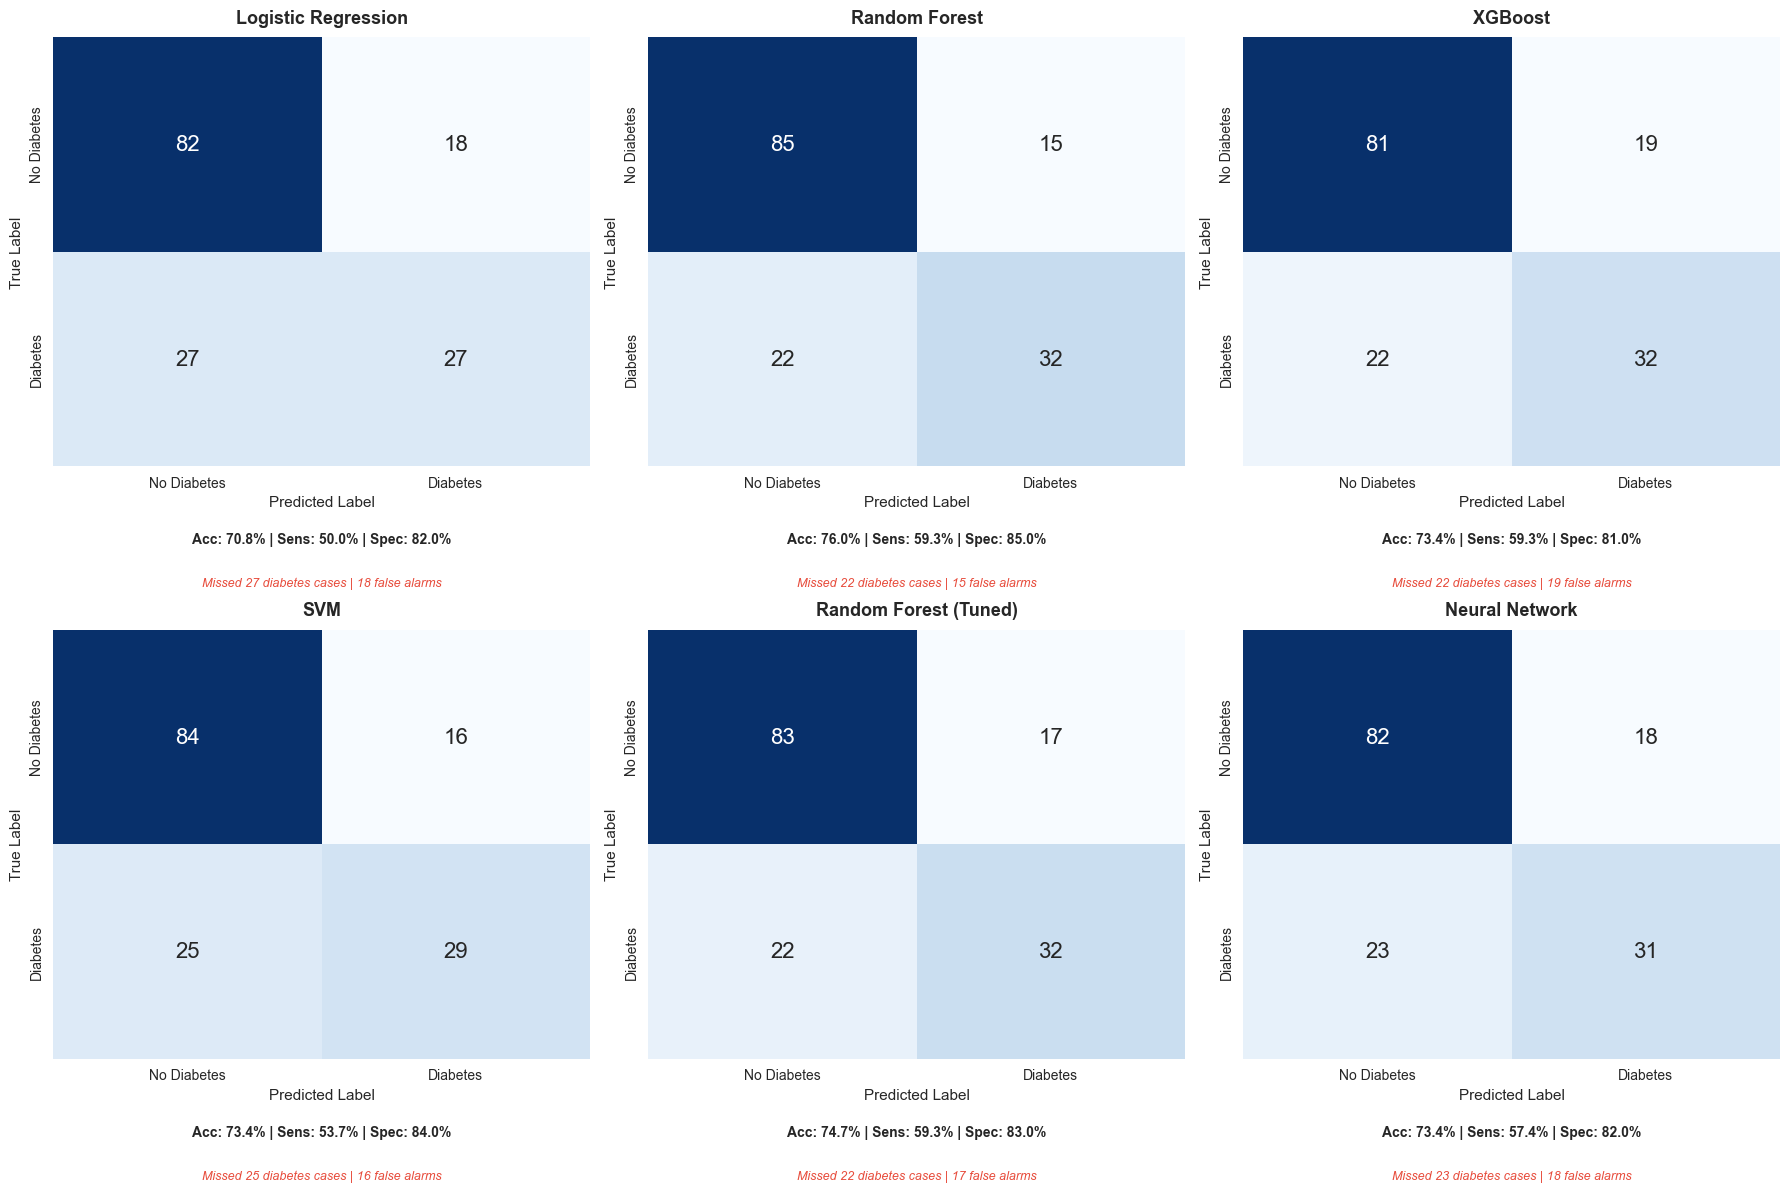


💡 Clinical Interpretation:
  • True Positives (TP): Correctly identified diabetes patients
  • False Negatives (FN): Missed diabetes cases - MOST DANGEROUS in healthcare
  • False Positives (FP): False alarms - leads to unnecessary follow-up
  • True Negatives (TN): Correctly identified healthy patients


In [42]:
# Create confusion matrices for all models
num_models = len(all_predictions)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx],
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'],
                annot_kws={"size": 16})
    
    axes[idx].set_title(f'{name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    
    # Add metrics below
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    text_str = f'Acc: {accuracy*100:.1f}% | Sens: {sensitivity*100:.1f}% | Spec: {specificity*100:.1f}%'
    axes[idx].text(0.5, -0.18, text_str, ha='center', transform=axes[idx].transAxes, 
                   fontsize=10, fontweight='bold')
    
    # Clinical interpretation
    axes[idx].text(0.5, -0.28, f'Missed {fn} diabetes cases | {fp} false alarms', 
                   ha='center', transform=axes[idx].transAxes, fontsize=9, style='italic', color='#e74c3c')

# Remove empty subplot if odd number of models
if num_models < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

print("\n💡 Clinical Interpretation:")
print("  • True Positives (TP): Correctly identified diabetes patients")
print("  • False Negatives (FN): Missed diabetes cases - MOST DANGEROUS in healthcare")
print("  • False Positives (FP): False alarms - leads to unnecessary follow-up")
print("  • True Negatives (TN): Correctly identified healthy patients")

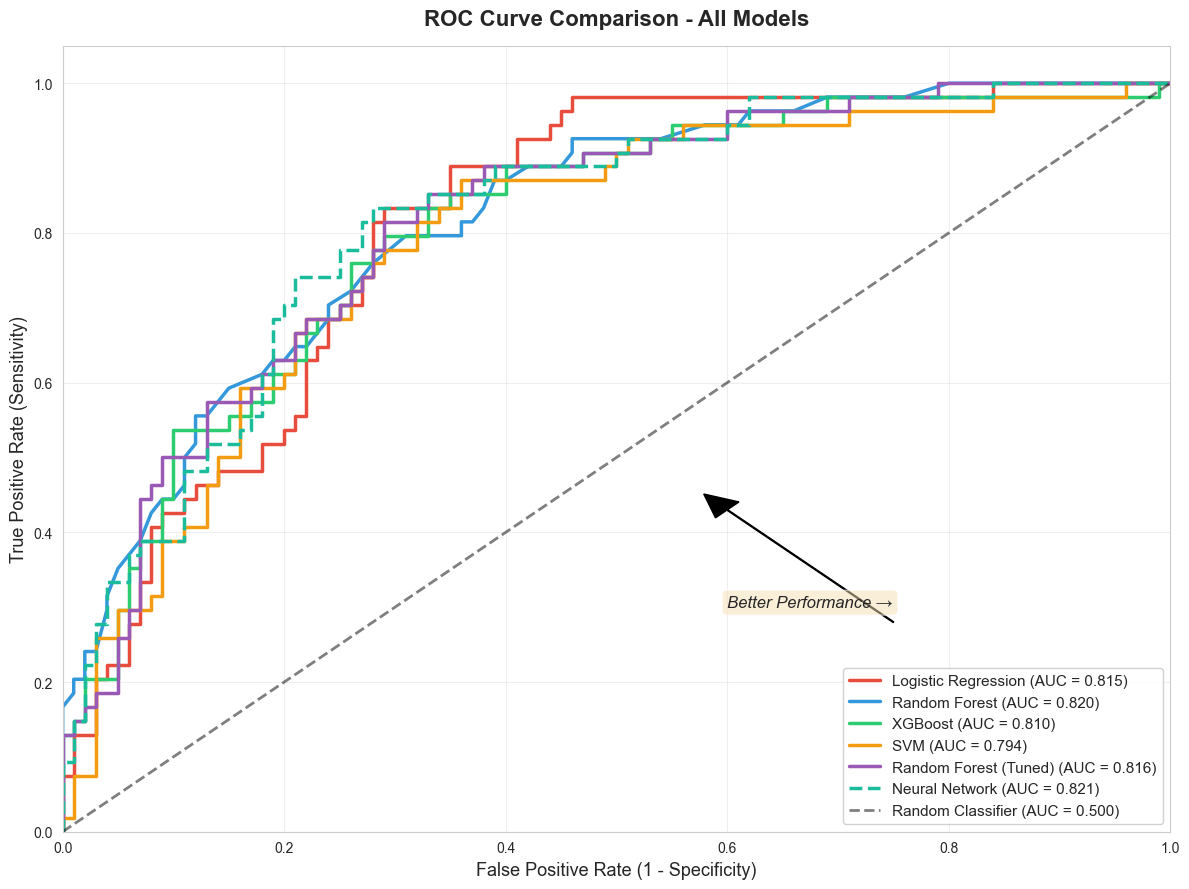


ROC AUC Performance Summary:
  Logistic Regression       AUC = 0.815  ⭐⭐ Excellent
  Random Forest             AUC = 0.820  ⭐⭐ Excellent
  XGBoost                   AUC = 0.810  ⭐⭐ Excellent
  SVM                       AUC = 0.794  ⭐ Acceptable
  Random Forest (Tuned)     AUC = 0.816  ⭐⭐ Excellent
  Neural Network            AUC = 0.821  ⭐⭐ Excellent


In [43]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 9))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
line_styles = ['-', '-', '-', '-', '-', '--']

for idx, (name, y_proba) in enumerate(all_probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, lw=2.5, label=f'{name} (AUC = {roc_auc:.3f})', 
             color=colors[idx], linestyle=line_styles[idx])

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13)
plt.title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)

# Add annotations
plt.text(0.6, 0.3, 'Better Performance →', fontsize=12, style='italic', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.arrow(0.75, 0.28, -0.15, 0.15, head_width=0.03, head_length=0.03, fc='black', ec='black')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ROC AUC Performance Summary:")
print("="*70)
for name, y_proba in all_probabilities.items():
    auc = roc_auc_score(y_test, y_proba)
    if auc >= 0.9:
        rating = "⭐⭐⭐ Outstanding"
    elif auc >= 0.8:
        rating = "⭐⭐ Excellent"
    elif auc >= 0.7:
        rating = "⭐ Acceptable"
    else:
        rating = "⚠️  Needs Improvement"
    print(f"  {name:25s} AUC = {auc:.3f}  {rating}")

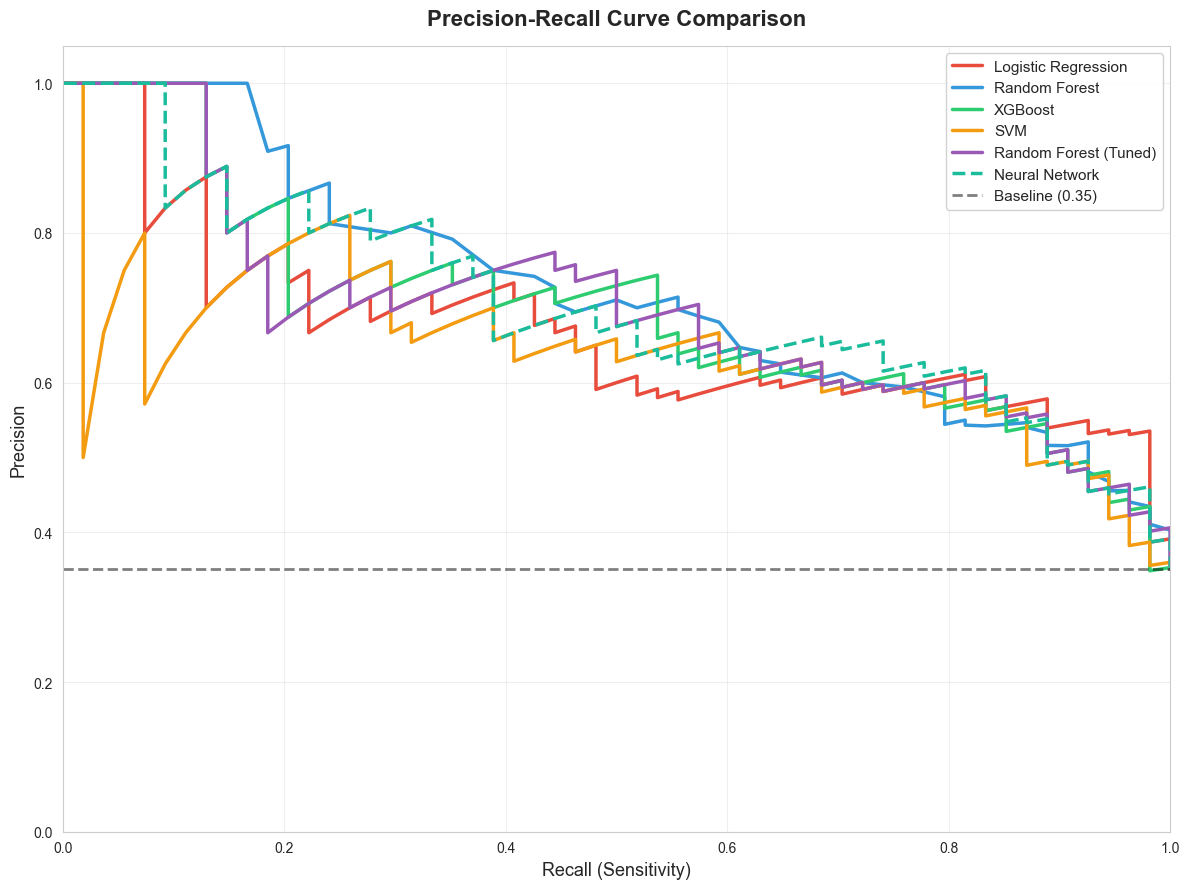


💡 Why Precision-Recall Matters in Healthcare:
  • Precision: Of patients we predict have diabetes, how many actually do?
  • Recall: Of all diabetes patients, how many did we successfully identify?

For diabetes screening:


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [44]:
# Plot precision-recall curves for all models
plt.figure(figsize=(12, 9))

for idx, (name, y_proba) in enumerate(all_probabilities.items()):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    plt.plot(recall, precision, lw=2.5, label=f'{name}', 
             color=colors[idx], linestyle=line_styles[idx])

# Baseline (random classifier for imbalanced data)
baseline = y_test.mean()
plt.plot([0, 1], [baseline, baseline], 'k--', lw=2, 
         label=f'Baseline ({baseline:.2f})', alpha=0.5)

plt.xlabel('Recall (Sensitivity)', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title('Precision-Recall Curve Comparison', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc="upper right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("\n💡 Why Precision-Recall Matters in Healthcare:")
print("  • Precision: Of patients we predict have diabetes, how many actually do?")
print("  • Recall: Of all diabetes patients, how many did we successfully identify?")
print("\nFor diabetes screening:")
print